In [1]:
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import numpy as np

path = 'drive/My Drive/Colab Notebooks/'

with open(path+"txt_data", "rb") as fp:   #Pickling
    data = pickle.load(fp)
with open(path+"txt_labels", "rb") as fp:   #Pickling
    labels = pickle.load(fp)
    
anomalies = []
y_anomalies = []
normal = []
y_normal = []
for x,y in zip(data,labels):
    if y>=6:
        anomalies.append(x)
        y_anomalies.append(-1)
    else:
        normal.append(x)
        y_normal.append(1)

data = None
labels = None

print(len(anomalies), len(y_anomalies), type(anomalies))
print(len(normal), len(y_normal), type(normal))

16157 16157 <class 'list'>
15545 15545 <class 'list'>


In [2]:
x_train_n, x_test_n= train_test_split(normal, test_size=0.10, random_state=33)

x_train = x_train_n 

x_test = []
y_testing = []
for x in x_train_n:
  x_test.append(x)
  y_testing.append(1)
for x in anomalies:
  x_test.append(x)
  y_testing.append(-1)

x_train, x_valid = train_test_split(x_train, test_size=0.1, random_state=32)
y_testing = np.array(y_testing)

print('training set', type(x_train), len(x_train))
print('testing set', type(x_test), len(x_test))
print('validation set', type(x_valid), len(x_valid))

training set <class 'list'> 12591
testing set <class 'list'> 30147
validation set <class 'list'> 1399


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, use_idf=True, stop_words='english')
vectorizer.fit(normal)
x_train = vectorizer.transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()
x_valid = vectorizer.transform(x_valid).toarray()
print('> tfidVectorization done.')

> tfidVectorization done.


- Autoencoder

In [4]:
import keras
from keras import *
from keras.layers import *

Using TensorFlow backend.


In [5]:
dim = x_train.shape[1]

inputs = Input(shape=(dim,))
encoded = Dense(400, activation='relu')(inputs)
decoded = Dense(150, activation='relu')(encoded)
decoded = Dense(400, activation='relu')(decoded)
decoded = Dense(dim, activation='sigmoid')(decoded)

autoencoderD = Model(inputs, decoded)
myAdam = keras.optimizers.Adam(learning_rate=0.00001)
autoencoderD.compile(optimizer=myAdam, loss='mse', metrics=['mse'])

autoencoderD.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               400400    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               60150     
_________________________________________________________________
dense_3 (Dense)              (None, 400)               60400     
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              401000    
Total params: 921,950
Trainable params: 921,950
Non-trainable params: 0
_________________________________________________________________


Train on 12591 samples, validate on 1399 samples
Epoch 1/20
12591/12591 [==============================] - 4s 320us/step - loss: 0.2372 - mse: 0.2372 - val_loss: 0.2071 - val_mse: 0.2071
Epoch 2/20
12591/12591 [==============================] - 2s 196us/step - loss: 0.1035 - mse: 0.1035 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 3/20
12591/12591 [==============================] - 2s 197us/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 4/20
12591/12591 [==============================] - 2s 192us/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/20
12591/12591 [==============================] - 2s 195us/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 6/20
12591/12591 [==============================] - 2s 195us/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 7/20
12591/12591 [==============================] - 2s 195us/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - v

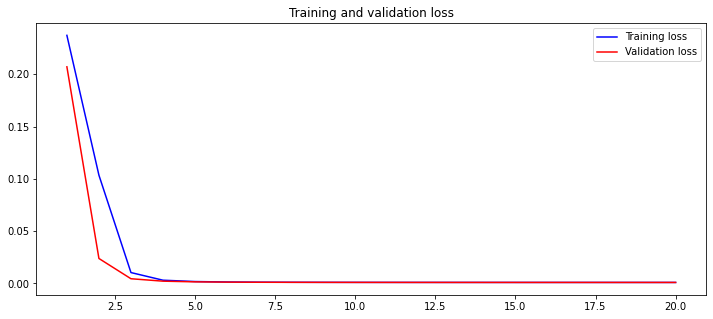

In [8]:
# fitting model
H = autoencoderD.fit( x_train, x_train, validation_data=(x_valid, x_valid), epochs=20, batch_size=32, verbose=1)

loss = H.history['loss']
val_loss = H.history['val_loss']
x = range(1, len(loss) + 1)
plt.figure(figsize=(12, 5))
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [9]:
predictions = autoencoderD.predict(x_test)
print(predictions.shape)
print(y_testing.shape)

(30147, 1000)
(30147,)


In [10]:
from sklearn.metrics import roc_curve, mean_squared_error, euclidean_distances

mse = []
rmse = []
ed = []
for original, decoded in zip(x_test, predictions):
    mse.append( mean_squared_error(original ,decoded ) )
    rmse.append( np.sqrt( mean_squared_error(original ,decoded ) ) )
    ed.append( np.sqrt( np.power( np.sum( original - decoded ) ,2) ) )
    
    
mse = np.array(mse)
rmse = np.array(rmse)
ed = np.array(ed)

tpr_mse_1, fpr_mse_1, thresholds_mse_1 = roc_curve(y_testing, mse, pos_label=1)
tpr_rmse_1, fpr_rmse_1, thresholds_rmse_1 = roc_curve(y_testing, rmse, pos_label=1)
tpr_ed_1, fpr_ed_1, thresholds_ed_1 = roc_curve(y_testing, ed, pos_label=1)

print('results ready')

results ready


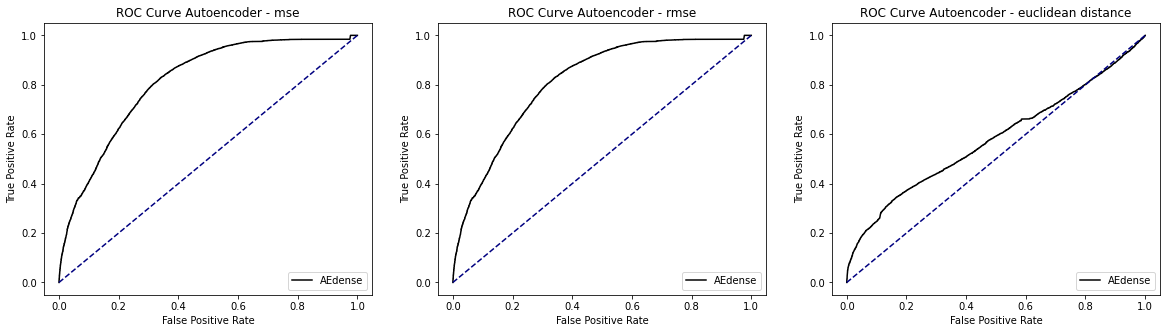

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(131)
#plt.plot(fpr_mse, tpr_mse, color='red', label='AEconv')
plt.plot(fpr_mse_1, tpr_mse_1, color='black', label='AEdense')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Autoencoder - mse')
plt.legend(loc='lower right')
plt.subplot(132)
#plt.plot(fpr_rmse, tpr_rmse, color='red', label='AEconv')
plt.plot(fpr_rmse_1, tpr_rmse_1, color='black', label='AEdense')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Autoencoder - rmse')
plt.legend(loc='lower right')
plt.subplot(133)
#plt.plot(fpr_ed, tpr_ed, color='red', label='AEconv')
plt.plot(fpr_ed_1, tpr_ed_1, color='black', label='AEdense')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Autoencoder - euclidean distance')
plt.legend(loc='lower right')
plt.show()

- One Class SVM

In [6]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

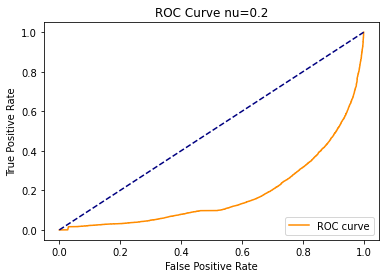

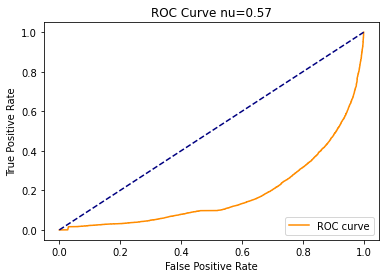

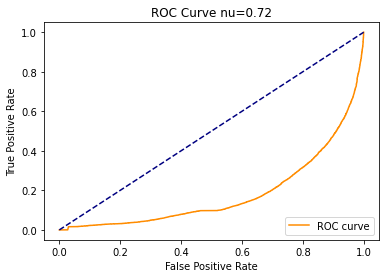

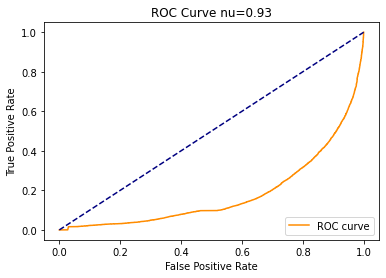

In [7]:
for nu_val in [0.2, 0.57, 0.72, 0.93]:
    model = OneClassSVM(kernel='rbf')
    model.fit(x_train)
    
    tpr, fpr, thresholds = roc_curve(y_testing, model.decision_function(x_test), pos_label=1)

    plt.figure(10)
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve nu=' + str(nu_val))
    plt.legend(loc="lower right")
    plt.show()
    plt.ion()